## 1  - Data Exploration

In [10]:
# imports 
import numpy as np
import pandas as pd 
import os
import random
!pip install xgboost
#import tensorflow as tf
import xgboost as xgb

# visualisation'
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style(style = 'darkgrid')
sns.set_palette('viridis')

%matplotlib inline

In [11]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
# add data from gender_submission
test['Survived'] = gender_submission['Survived']

print('Test data')
test.head()

Test data


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [13]:
print('---Train data---')
print('Data Shape: {:,d} rows X {:d} columns'.format(train.shape[0], train.shape[1]))
print('Total no. of passengers: {:,d}'.format(len(train)))
# print('Number of unique tickets: {:d}'.format(train['Ticket'].nunique()))
print('Number of unique Passenger Classes: {:,d}'.format(train['Pclass'].nunique()))
print('Number of unique Fare amounts: {:,d}'.format(train['Fare'].nunique()))
print()

print('---Test data---')
print('Data Shape: {:,d} rows X {:d} columns'.format(test.shape[0], test.shape[1]))
print('Total no. of passengers: {:,d}'.format(len(test)))
# print('Number of unique tickets: {:,d}'.format(test['Ticket'].nunique()))
print('Number of unique Passenger Classes: {:,d}'.format(test['Pclass'].nunique()))
print('Number of unique Fare amounts: {:,d}'.format(test['Fare'].nunique()))

---Train data---
Data Shape: 891 rows X 12 columns
Total no. of passengers: 891
Number of unique Passenger Classes: 3
Number of unique Fare amounts: 248

---Test data---
Data Shape: 418 rows X 12 columns
Total no. of passengers: 418
Number of unique Passenger Classes: 3
Number of unique Fare amounts: 169


## 1.1 Feature Exploration

Categorical and Continuos Features

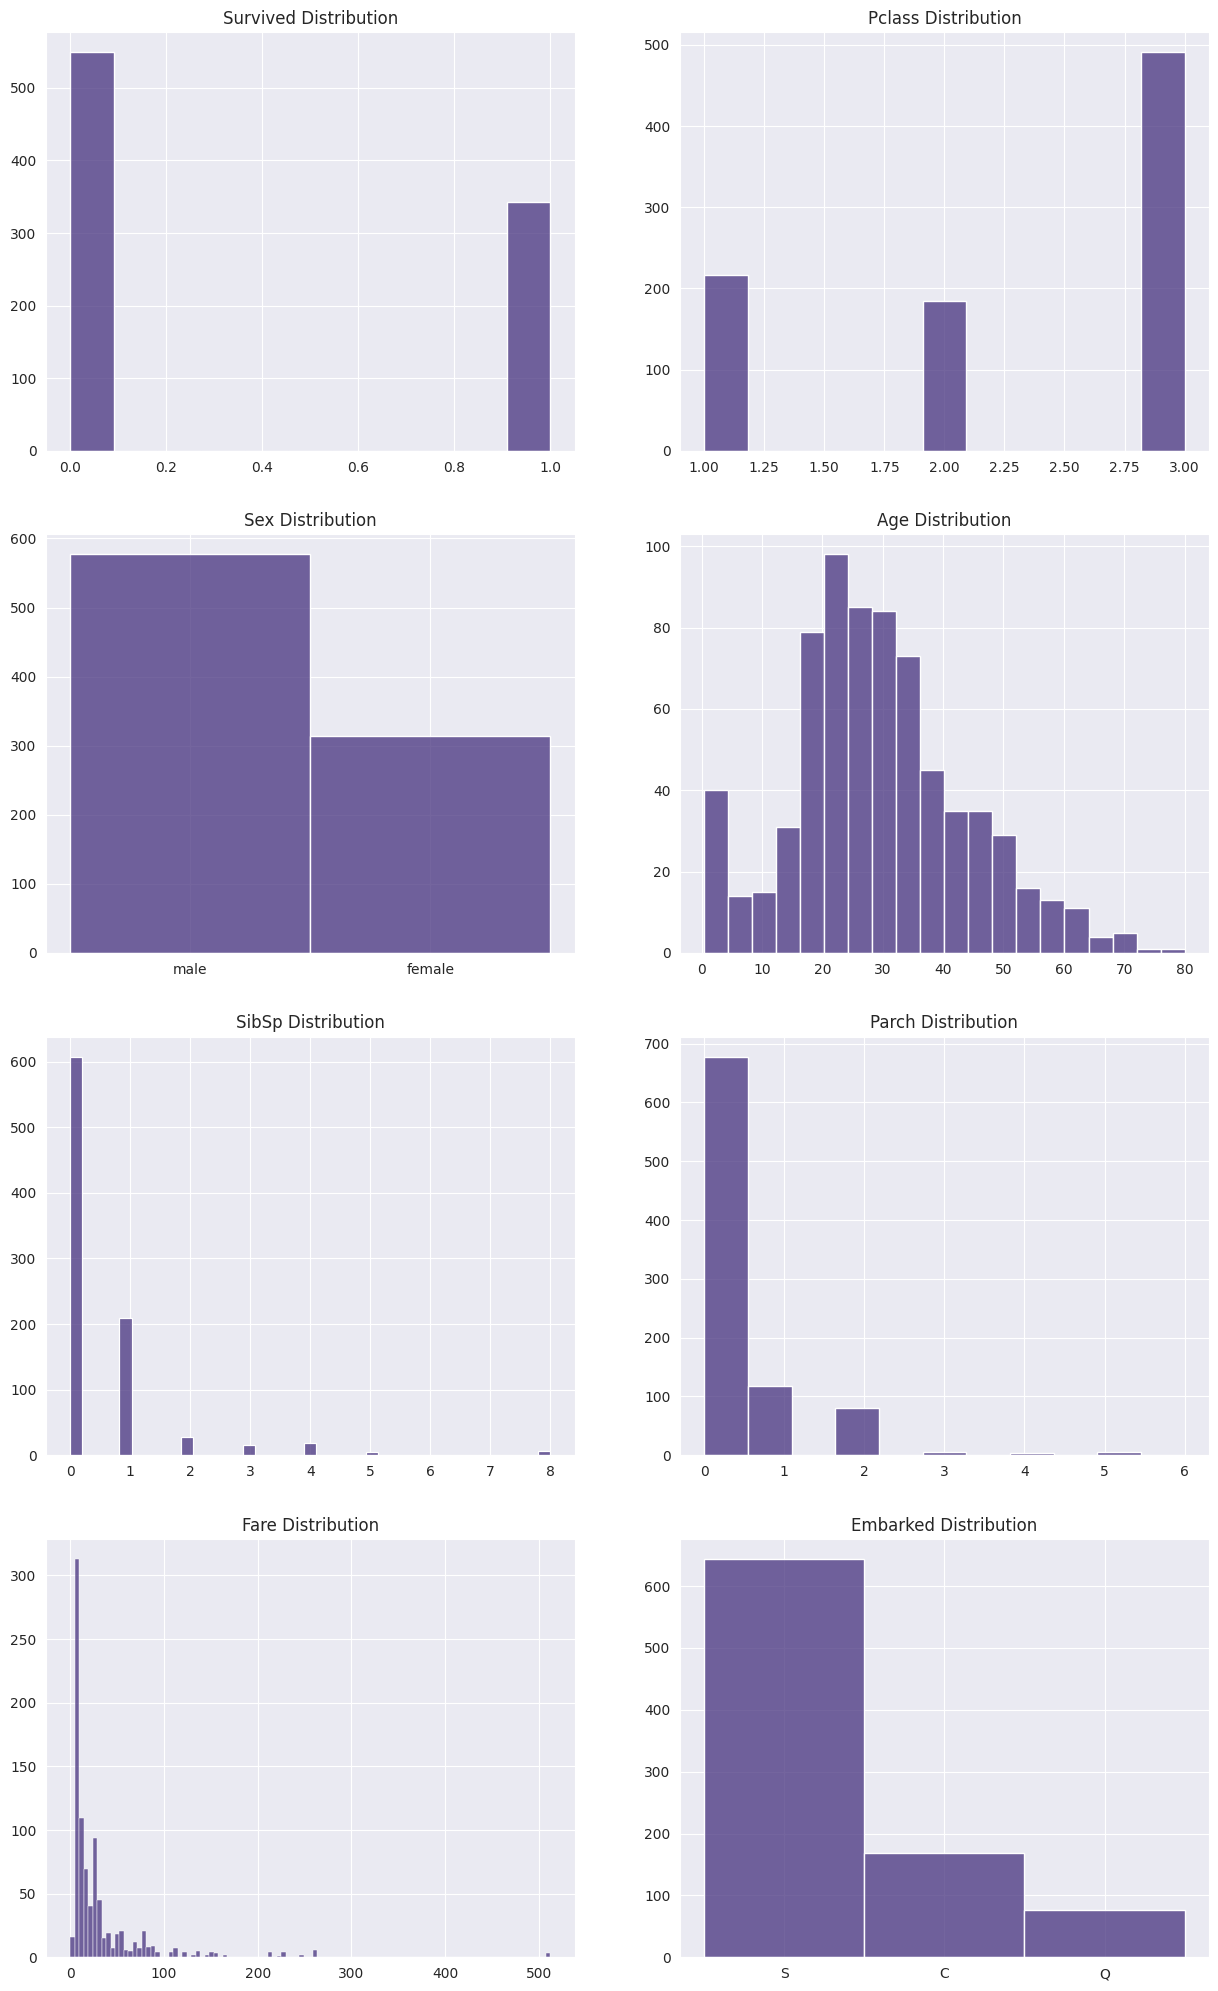

In [14]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize =(15,25))

train_copy = train.copy()
features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
axs = axs.flatten()

for i, feature in enumerate(features):
    _ = sns.histplot(train_copy, x="{}".format(feature), ax=axs[i])
    _ = axs[i].set_title("{} Distribution".format(feature))
    _ = axs[i].set_ylabel("")
    _ = axs[i].set_xlabel("")

## 1.2 Spearman Correlation

/tmp/ipykernel_12833/3799238179.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train[features].corr('spearman')


<AxesSubplot: >

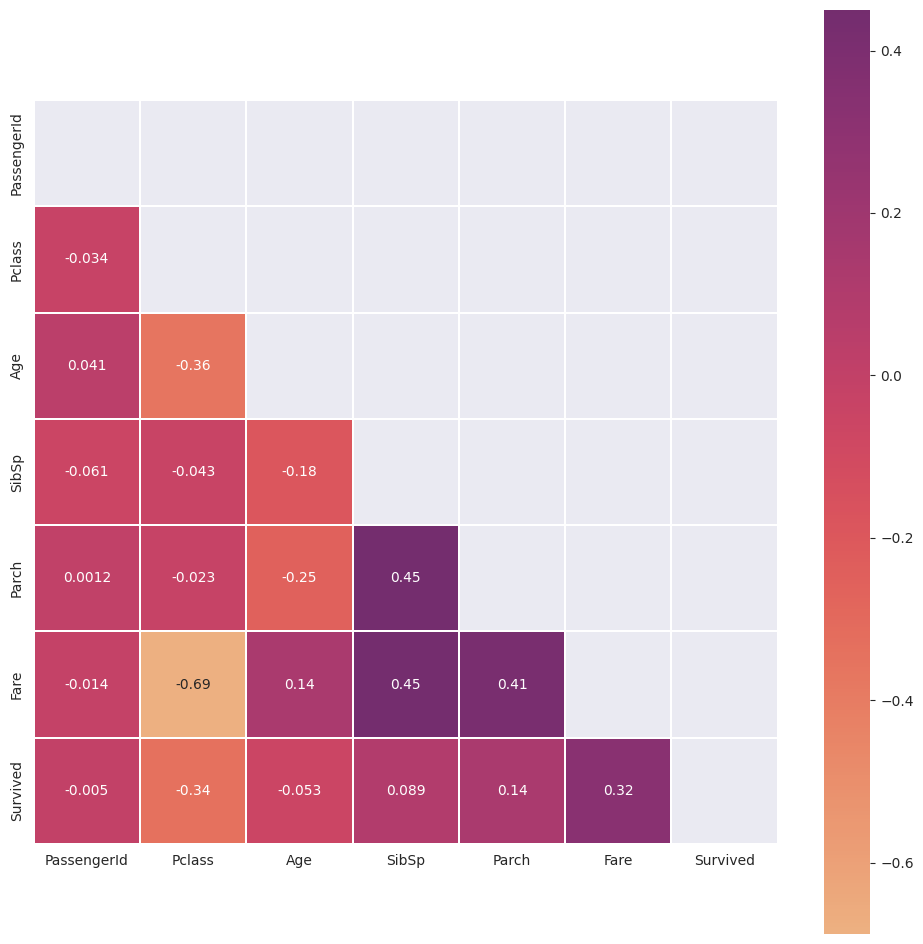

In [15]:
plt.figure(figsize = (12,12))
features = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
           'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

corr_matrix = train[features].corr('spearman')
sns.heatmap(corr_matrix, 
            annot = True, 
            cmap = 'flare', 
            mask = np.triu(np.ones_like(corr_matrix, dtype = bool)),  
            center = 0,
            square = True, 
            linewidths = 0.1 )

## 2 - Missing Data

In [16]:
print('Percentage of missing data per feature in the train set:')
100 * train.isnull().sum() / len(train)

Percentage of missing data per feature in the train set:


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [17]:
print('Percentage of missing data per feature in the test set:')
100 * test.isnull().sum() / len(test)

Percentage of missing data per feature in the test set:


PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
Survived        0.000000
dtype: float64

## 2.1 Age (Train & Test)

In [18]:
features = ["Age"]
train[features].describe().T.style.bar(
    subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000


/tmp/ipykernel_12833/4213715170.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = 'Age', data = train, palette = 'flare', bins = 40)


<AxesSubplot: xlabel='Age', ylabel='Count'>

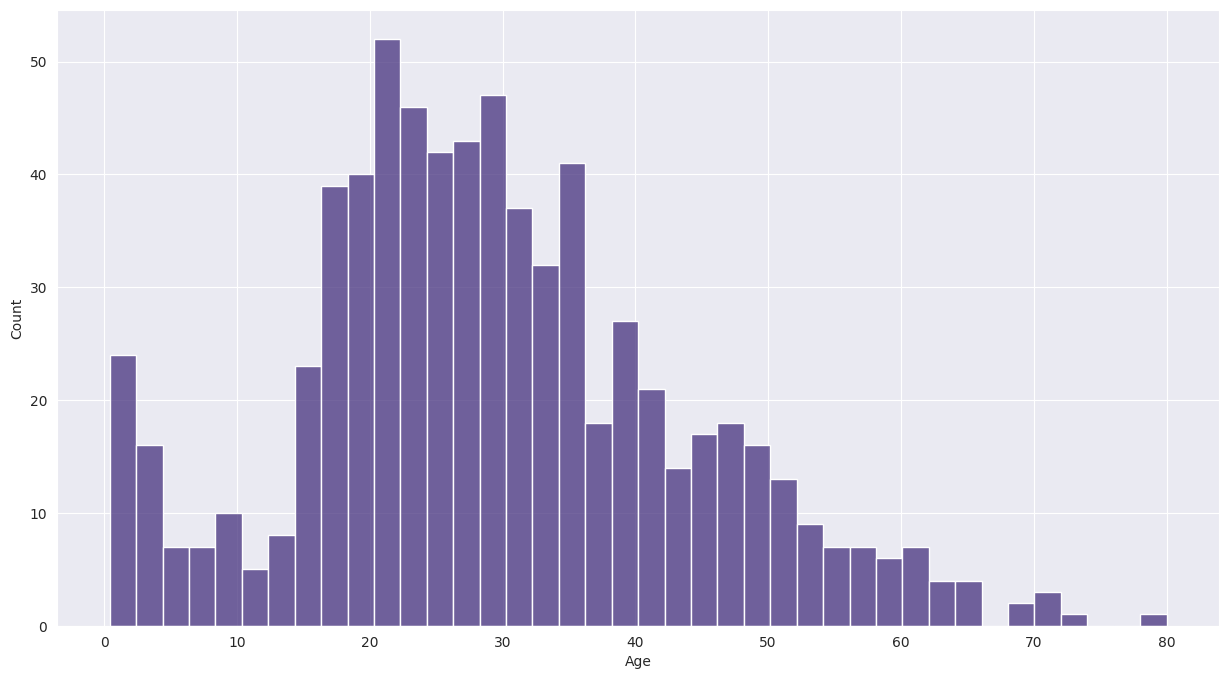

In [19]:
plt.figure(figsize = (15, 8))
sns.histplot(x = 'Age', data = train, palette = 'flare', bins = 40)

In [20]:
print('Age grouped by Pclass:') 
train.groupby('Pclass')['Age'].describe().style.bar(
     subset=['mean'], color = '#7BCC70')\
    .background_gradient(subset = ['std'], cmap = 'flare')\
    .background_gradient(subset = ['50%'], cmap = 'flare') 

Age grouped by Pclass:


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.000000,38.233441,14.802856,0.920000,27.000000,37.000000,49.000000,80.000000
2,173.000000,29.877630,14.001077,0.670000,23.000000,29.000000,36.000000,70.000000
3,355.000000,25.140620,12.495398,0.420000,18.000000,24.000000,32.000000,74.000000


In [21]:
 print('Age grouped by Sex:') 
train.groupby('Sex')['Age'].describe().style.bar(
     subset=['mean'], color = '#7BCC70')\
    .background_gradient(subset = ['std'], cmap = 'flare')\
    .background_gradient(subset = ['50%'], cmap = 'flare') 

Age grouped by Sex:


,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.000000,27.915709,14.110146,0.750000,18.000000,27.000000,37.000000,63.000000
male,453.000000,30.726645,14.678201,0.420000,21.000000,29.000000,39.000000,80.000000


In [22]:
# utility 
data = train.groupby(['Pclass','Sex'])['Age'].mean()
print("Utility data")
data

Utility data


Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [23]:
# function to fill null age values
def fill_age(pclass, sex, age):
    '''
    takes in the pclass, sex and age 
    if the age is null, then extracts the age from 'data'and returns the corrosponding age
    else returns the original age
    '''
    if np.isnan(age): 
        return data.loc[(pclass, sex)]
    else: 
        return age
    
# filling the missing values in both datasets
train['Age'] = train.apply(lambda x: fill_age(x['Pclass'], x['Sex'], x['Age']), axis=1)
test['Age'] = test.apply(lambda x: fill_age(x['Pclass'], x['Sex'], x['Age']), axis=1)            

## 2.2 Fare (Test only)

In [24]:
# function to fill missing fare in test dataset
def fill_fare(fare):
    '''
    takes in fare if null
    returns the most common value
    '''
  
    if np.isnan(fare):
        return round(test['Fare']).value_counts().max()
    else:
        return fare
    
test['Fare'] = test.apply(lambda x: fill_fare(x['Fare']), axis=1)  

## 2.3 Embarked (Train only)

In [25]:
# storing the most common 'Embarked' value
common_value = train['Embarked'].value_counts().idxmax()

In [26]:
# filling all null values
train['Embarked'] =train['Embarked'].fillna(common_value)

In [27]:
# check
train['Embarked'].isnull().sum()

0

## 2.4 Cabin (Train & Test)

Since 80% of the 'Cabin' data is missing in both train and test datasets, dropping the coulmn altogether in both datasets. The column is dropped in section 3.2.

## 3 Data Preprocessing
* Feature processing
* Dropping columns that are not useful
* Creating Dummy Variables
* Scaling 
* Data Split

## 3.1 Extracting titles from 'Name' 
We cannot use the whole name as there are a lot of unique names. But all the names have a title that is associated with the person. We can extract the titles and convert them into dummies.


In [28]:
# storing the most common titles 
titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Other', 'Mlle', 'Ms', 'Mme']

In [29]:
# function to extract the tile 
def extract_title(name):
    '''
    takes in the name feature
    splits the name based on space and creates a list 
    stores in the 2nd item (title) in the variable 'title'
    
    if the title is not among the common titles, returns 'Other'
    else returns the title 
    '''

    title = name.split('.')[0].split(' ')[-1]
    
    if title not in titles:
        return titles[4]
    else:
        return title


In [30]:
# extracting the title in a different coulmn
train['Title'] = train.apply(lambda x: extract_title(x['Name']), axis=1)
test['Title'] = test.apply(lambda x: extract_title(x['Name']), axis=1)  

In [31]:
# replacing 
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

# replacing 
test['Title'] = test['Title'].replace('Ms', 'Miss')

## 3.2 Dropping Unhelpful Data

In [32]:
# dropping columns that are not helpful
train_df = train.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis = 1)
test_df = test.drop(['Cabin', 'Name','Ticket'], axis = 1)

In [33]:
train_df.head(0)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title


In [34]:
test_df.head(0)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Title


## 3.3 Dummy Variables

In [35]:
# converting the values into dummies
dummies = pd.get_dummies(train_df[['Sex', 'Embarked', 'Title']], drop_first = True)

# adding these to train_df
train_df = pd.concat([train_df, dummies], axis = 1)

# dropping the OG columns
train_df = train_df.drop(['Sex', 'Embarked', 'Title'], axis = 1)

print('Train Data after dummy variables:')
train_df.head()

Train Data after dummy variables:


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,3,22.0,1,0,7.2500,1,0,1,0,1,0,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,0,1,0
2,1,3,26.0,0,0,7.9250,0,0,1,1,0,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,1,0
4,0,3,35.0,0,0,8.0500,1,0,1,0,1,0,0


In [36]:
# converting the values into dummies
dummies = pd.get_dummies(test_df[['Sex', 'Embarked', 'Title']], drop_first = True)

# adding these to train_df
test_df = pd.concat([test_df, dummies], axis = 1)

# dropping the OG columns
test_df = test_df.drop(['Sex', 'Embarked', 'Title'], axis = 1)

print('Train Data after dummy variables:')
test_df.head(1)

Train Data after dummy variables:


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,892,3,34.5,0,0,7.8292,0,1,1,0,0,1,0,0


## 3.4 Labels

In [37]:
# define the labels
X_train = train_df.drop('Survived', axis = 1)
y_train = train_df['Survived']

X_test = test_df.drop(['PassengerId', 'Survived'], axis = 1)
y_test = test_df['Survived']

## 3.5 Data Split

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = seed_value)

In [39]:
# utility
train_columns = X_train.columns

## 3.6 Scaling

In [40]:
# import 
from sklearn.preprocessing import MinMaxScaler

# creating an instance of the scaler
scaler = MinMaxScaler()

# using .fit_transform() on the train and val data
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

# using only fit for the test data for no leaks
X_test = scaler.transform(X_test)

## 4 - Model

* Creating a Random Forest Classifier
* Get the best estimator via GridSearch
* Re-train with the best estimator
* Cross Validation
* Feature Importance
* Submission

## 4.1 Model 

In [41]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

RandomForestClassifier()

## 4.2 Best parameter

In [42]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {'n_estimators': [10, 50, 100, 200, 500, 600, 800, 850]}

# Create the random forest classifier
clf = RandomForestClassifier()

# Set up the grid search
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best value of n_estimators
best_n_estimators = grid_search.best_params_['n_estimators']

print("Best value of n_estimators:", best_n_estimators)

Best value of n_estimators: 500


## 4.2 Re-train

In [43]:
clf = RandomForestClassifier(n_estimators = 500)

clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

## 4.3 Cross Validation

In [44]:
from sklearn.model_selection import cross_val_score

# Evaluate the classifier using 5-fold cross-validation
scores_5 = cross_val_score(clf, X_val, y_val, cv=5)

# Print the mean and standard deviation of the scores
print("5-fold cross-validation: %0.2f (+/- %0.2f)" % (scores_5.mean(), scores_5.std()))

5-fold cross-validation: 0.79 (+/- 0.06)


## 4.4 Feature Importance

In [45]:
importances = pd.DataFrame({'feature':train_columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

print('Feature Importance:')
importances

Feature Importance:


,importance
feature,
Fare,0.247
Age,0.224
Title_Mr,0.134
Sex_male,0.115
Pclass,0.079
SibSp,0.056
Title_Mrs,0.043
Parch,0.035
Title_Miss,0.029


<AxesSubplot: xlabel='feature'>

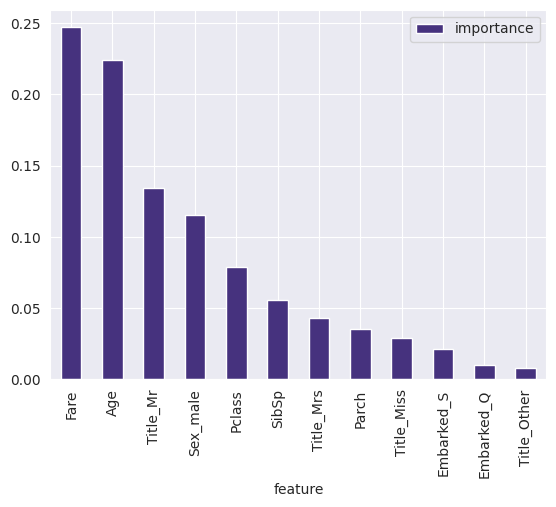

In [46]:
importances.plot.bar()

## 4.5 Evaluation

In [47]:
predictions = clf.predict(X_test)

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print('Classification Report:')
print()
print(classification_report(y_test, predictions))

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       266
           1       0.88      0.81      0.85       152

    accuracy                           0.89       418
   macro avg       0.89      0.87      0.88       418
weighted avg       0.89      0.89      0.89       418



Confusion Matrix:



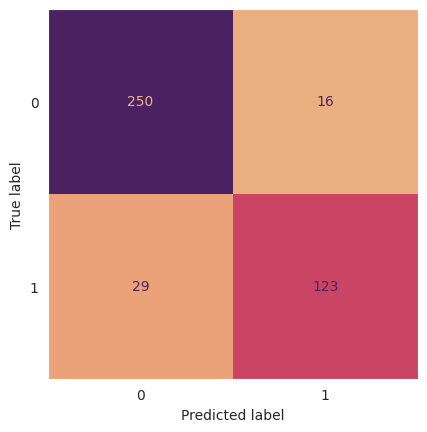

In [49]:
print('Confusion Matrix:')
print()
ConfusionMatrixDisplay.from_predictions(y_test, predictions, colorbar = False, cmap = 'flare')
plt.grid(False)

## 4.6 Submission

In [50]:
submission = pd.DataFrame(predictions, columns = ['Survived'])
submission = pd.concat([test['PassengerId'], submission], axis = 1)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [51]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [52]:
submission['Survived'].value_counts()

0    279
1    139
Name: Survived, dtype: int64

In [53]:
submission = submission.to_csv('kaggle_titanic.csv',index=False)